# Homework:  

For all the problems, you may obtain $\{\omega_i, \xi_i \}$ directly from Julia's `FastGaussQuadrature` packages. For instance, `xi, wi = gausslegendre(20)` would give $\{\omega_i, \xi_i \}$, $i=1,\ldots,20$, from the Gauss-Legendre rule.

## This problem asks you to adopt the Gauss-Hermite rule to an infinite integral where the weight function does not match.  The integration problem is:
  $$\begin{aligned}
   I = \int_{-\infty}^\infty g(x) d x =  \int_{-\infty}^\infty \exp\left(-\frac{1}{3}x^2\right)\sqrt{1+x^2} dx.
  \end{aligned}$$ 
 

- ##### Let's do this without using changes of variables. 
  - Transform $g(x)$ to $e^{-x^2}f(x)$ so that the Gauss-Hermite rule could be applied. Write down the re-formulated integration problem explicitly and write down $f(x)$ explicitly.
  - Write Julia code to integrate the function numerically.

function_form = LaTeXStrings.LaTeXString("\$\\frac{1}{1+x}\$")Answer Key:

<blockquote>

Let $g(x) = \exp\left(-\frac{1}{3}x^2\right)\sqrt{1+x^2}$. In order to apply Gauss-Hermite rule, we need to assign $\exp(-x^2)$ as the weight function, which is then offset by multiplying $\exp(x^2)$ to $g(x)$. That is,
 
   $$\begin{aligned}
   I  = \int_{-\infty}^\infty g(x) dx  =   & \int_{-\infty}^\infty \exp(-x^2)\underbrace{\left[ \exp(x^2)g(x) \right]}_{\equiv f(x)} dx \\
      = &  \int_{-\infty}^\infty \exp(-x^2)f(x) dx
  \end{aligned}$$
  
Then we can apply the Gauss-Hermite rule: $\int_{-\infty}^\infty \exp(-x^2)f(x) dx \approx \sum_{i=1}^{n} \omega_i f(\xi_i)$ where $f(x) = \exp(x^2)g(x)$.
    
Essentially, we could multiply the _**inverse**_ of the weight function $\exp(x^2)$ to any function $g(x)$ to get $f(x) = \exp(x^2)g(x)$, and then apply the Gauss-Hermite rule to $f(x)$ to get the integration of $g(x)$ from $-\infty$ to $\infty$.
  
</blockquote>   

## import module

In [2]:
using Plots, Distributions, FastGaussQuadrature

In [2]:
g(x) = exp(-(x^2)/3)*sqrt(1+x^2)   # original integrand
p(x) = exp(-x^2)    # weight function (not actually used)
invp(x) = exp(x^2)  # inverse of the weight function
f(x) = invp(x)g(x)  # transformed integrand

xi, wi = gausshermite(30)

answer = sum(wi .* f.(xi))
@show answer

#--- Or, we may define a function to do the integration --

function myGH_Int(gfun::Function; n::Integer=10)
    xi, wi = gausshermite(n)
    res = sum(wi .* exp.(xi.^2) .* gfun.(xi))
    return res
end

@show myGH_Int(g; n=30)


answer = 4.5638130088853694
myGH_Int(g; n = 30) = 4.5638130088853694


4.5638130088853694

## Write a Julia function with the following specifications.
  - It calculates $E[g(y)]$ for any arbitrary $g(y)$ where $y \sim N(\mu, \sigma^2)$.
  - User's inputs include $g(y)$, $\mu$, $\sigma^2$, and $n$.
  - You may obtain $\{\omega_i, \xi_i\}$ directly from Julia's package.
  - If $g(y) = 1 + 3y + y^2$, $y \sim N(1,2)$, and $n=30$, the interface could be like `myInteg(1 + 3y + y^2, mean=1, variance=2, n=30)`, or, `myInteg(g, mean=1, variance=2, n=30)`.
  - Hint: You may define the probability density function of $y$ using the `Distributions` package and then `pdf(Normal(mean, variance),x)`.

In [3]:
function myInteg(g::Function, mu::Float64, var::Float64, n::Int64)
    objec_func(x) = g(x) * pdf(Normal(mu, sqrt(var)), x)
    invp(x) = exp(x^2)
    f(x) = invp(x) * objec_func(x)
    xi, wi = gausshermite(n)
    return f.(xi)' * wi
end

g(y) = 1 + 3y + y^2
myInteg(g, 1., 2., 30)

6.999792968988663

## It is generally true that proper integrals (i.e., with finite domains) are numerically easier to deal with. But what if a problem is naturally a GH type with an infinite domain and we transform it to a GL problem with a finite domain? Is the GL rule better in this scenario? Let's find out the answer. Consider the following integration problem which is often encountered in econometric analysis. 

$$\begin{aligned}
      I = \int_{-\infty}^\infty \Phi\left(\frac{x-a}{b}\right)\phi(x) dx,
\end{aligned}$$

where $X\sim N(0,1)$ is a standard normal random variable, $\phi(z)$ is the density function (PDF) of a random variable $z$, and $\Phi(z)$ is the CDF of $z$.
   - ##### Write a Julia function that uses the GH rule to approximate the integral. The program should be a function of $a$ and $b$.
   - ##### Transform this problem to the GL type. What is the transformation rule and what is the Jacobian? Type the equations and show your work.
   - ##### Write a Julia function that uses the GL rule to approximate the integral. The program should be a function of $a$ and $b$.
   - ##### Suppose the required precision is 6 digits after the decimal. Compare the performances of these functions. Which one converges more quickly (smaller $n$)? You may pick values of $a$ and $b$ to do the comparison. You may draw graphs to compare the results.
   - ##### Based on your results, is the GL rule always the most efficient?

(GH_result[n], GL_result[n]) = (0.2635446283352552, 0.26336031731738674)


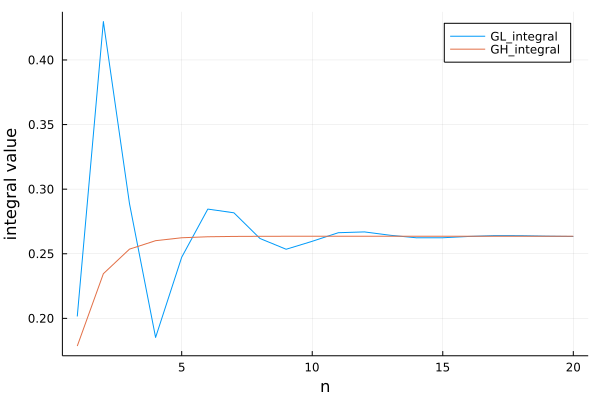

In [23]:
function GL_integral(a, b, n)
    objec_func(x) = cdf(Normal(0, 1), ((x-a)/b)) * pdf(Normal(0, 1), x)
    trans_rule(t) = t / (1-t^2)
    jacobian(t) = (t^2+1) / (t^2-1)^2
    f(t) = objec_func(trans_rule(t)) * jacobian(t) 
    x_i, w_i = gausslegendre(n)
    return f.(x_i)' * w_i
end


function GH_integral(a, b, n)
    objec_func(x) = cdf(Normal(0, 1), ((x-a)/b)) * pdf(Normal(0, 1), x)
    invp(x) = exp(x^2)
    f(x) = invp(x) * objec_func(x)
    x_i, w_i = gausshermite(n)
    return f.(x_i)' * w_i
end


function main()
    a, b, n = 2, 3, 20
    GL_result = zeros(n)
    GH_result = zeros(n)
    for i = 1:n
        GL_result[i], GH_result[i] = GL_integral(a, b, i), GH_integral(a, b, i)
    end
    plot(GL_result, label="GL_integral")
    plot!(GH_result, label="GH_integral", xlabel="n", ylabel="integral value")
end

main()

## This problem asks you to consider an integration problem where it can be transformed to different types to use different Gaussian quadrature rules. Which one is the best? The integration problem is:

 $$\begin{aligned}
 \int_{a}^\infty \exp\left(-\frac{1}{100}x^2\right)(1+x^2) dx,
 \end{aligned}$$

where $a$ is finite but not necessarily 0. This problem has some characteristics of the GLa and GH types: It has an exponential function, and by mapping $a$ to $-1$, $0$ or $-\infty$ via change of variables, the domain would be of the GL, GLa and GH types, respectively. You are asked to perform the approximation using rules of each of the types and compare the performance. In the code, make $a$ a parameter that we can assign a value to it.

 - ##### Write Julia code that uses the GL rule to approximate the integral. 
 - ##### Write Julia code that uses the GLa rule to approximate the integral. 
 - ##### Write Julia code that uses the GH rule to approximate the integral. 
 - ##### Suppose the required precision is 6 digits after the decimal. Compare the performances of these functions; drawing a graph will be useful. You may pick a value for $a$ in the comparison. 

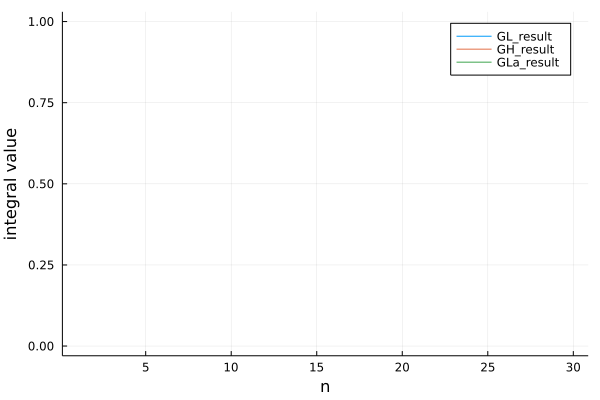

In [3]:
function GL_integral(a, n)
    objec_func(x) = exp(-x^2/100) * (1+x^2)
    trans_rule(t) = a + ((1+t)/(1-t))
    jacobian(t) = 2 / (t-1)^2
    f(t) = objec_func(trans_rule(t)) * jacobian(t) 
    x_i, w_i = gausslegendre(n)
    return f.(x_i)' * w_i
end


function GH_integral(a, n)
    objec_func(x) = exp(-x^2/100) * (1+x^2)
    trans_rule_1(t) = a + ((1+t)/(1-t))
    trans_rule_2(t) = (-1+sqrt(1+4*t^2)) / (2*t)
    jocobian(t) = (2/(trans_rule_2(t)-1)^2) *
                  ((8*t^2*(sqrt(1+4*t^2))^(-1))-(2*(-1+sqrt(1+4*t^2)))) / (4*t^2)
    invp(x) = exp(x^2)
    f(t) = invp(t) * objec_func(trans_rule_1(trans_rule_2(t))) * jocobian(t)
    x_i, w_i = gausshermite(n)
    return f.(x_i)' * w_i
end


function GLa_integral(a, n)
    objec_func(x) = exp(-x^2/100) * (1+x^2)
    trans_rule(t) = a + t
    invp(x) = exp(x)
    f(t) = invp(t) * objec_func(trans_rule(t)) * 1
    x_i, w_i = gausslaguerre(n)
    return f.(x_i)' * w_i
end


function main()
    a, n = -Inf, 30
    GL_result = zeros(n)
    GH_result = zeros(n)
    GLa_result = zeros(n)
    for i = 1:n
        GL_result[i], GH_result[i], GLa_result[i] = GL_integral(a, i), GH_integral(a, i),
                                                    GLa_integral(a, i)
    end
    plot(GL_result, label="GL_result")
    plot!(GH_result, label="GH_result")
    plot!(GLa_result, label="GLa_result", xlabel="n", ylabel="integral value")
end


main()

## Let's try the integration of a truncated normal distribution. 

A truncated normal random variable $X$ $(>0)$ is presented as $N^+(\mu, \sigma^2)$ where "$+$" indicates a truncation from above at 0. The CDF function is:

$$\begin{align}
\mathrm{trun\_CDF} = \int_0^b \frac{1}{\Phi\left( \frac{\mu}{\sigma} \right)} \frac{1}{\sqrt{2 \pi} \sigma } e^{-\frac{1}{2}\left(\frac{x-\mu}{\sigma} \right)^2}dx
\end{align}$$


- Write a Julia function using the Gauss-Legendre rule for `trun_CDF` where $\mu$, $\sigma$, $b$, and $n$ are the function's parameters.
- Write a Julia function using the Gauss-Laguerre rule for `trun_CDF` where $\mu$, $\sigma$, $b$, and $n$ are the function's parameters.


GLa_result[n] = 0.7495403418093766


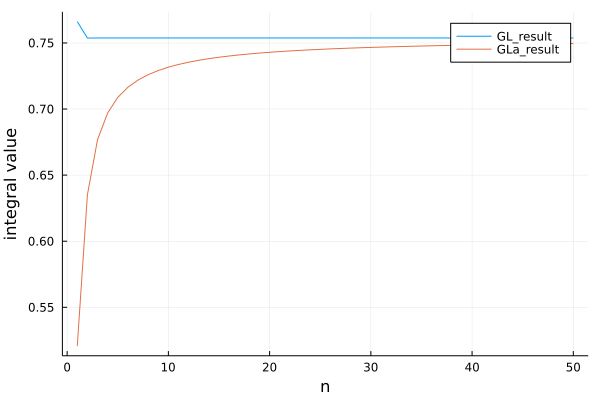

In [27]:
function GL_integral(mu, sig, b, n)
    objec_func(x) =  pdf(Normal(mu, sig), x) / cdf(Normal(mu, sig), (mu/sig))
    trans_rule(t) = (b/2) + ((b*t)/2)
    jacobian = b / 2
    f(t) = objec_func(trans_rule(t)) * jacobian
    x_i, w_i = gausslegendre(n)
    return f.(x_i)' * w_i
end


function GLa_integral(mu, sig, b, n)
    objec_func(x) =  pdf(Normal(mu, sig), x) / cdf(Normal(mu, sig), (mu/sig))
    trans_rule_1(t) = (b/2) + ((b*t)/2)
    trans_rule_2(t) = (t-1) / (t+1)
    jacobian(t) = (b / 2) * (2/(t+1)^2)
    invp(x) = exp(x)
    f(t) = invp(t) * objec_func(trans_rule_1(trans_rule_2(t))) * jacobian(t)
    x_i, w_i = gausslaguerre(n)
    return f.(x_i)' * w_i
end



function main()
    mu, sig, b, n = 2, 3, 2, 50
    GL_result = zeros(n)
    GLa_result = zeros(n)
    for i = 1:n
        GL_result[i], GLa_result[i] = GL_integral(mu, sig, b, i), GLa_integral(mu, sig, b, i)
    end
    @show GLa_result[n]
    plot(GL_result, label="GL_result")
    plot!(GLa_result, label="GLa_result", xlabel="n", ylabel="integral value")
end

main()